In [1]:
using Interpolations, Distributions, ForwardDiff, LinearAlgebra, FastGaussQuadrature, Plots
using Memoize, BenchmarkTools

abstract type Component end
abstract type Scatterer end
abstract type Model end

function flattenall(A)
    V = []
    for x in A
        if isa(x, AbstractArray)
            append!(V, flattenall(x))
        else
            push!(V, x)
        end
    end
    V
end

flattenall (generic function with 1 method)

In [2]:
# data stuff
using DelimitedFiles


mutable struct Data1D
    x::Vector
    y::Vector
    yerr::Union{Vector, Nothing}
    xerr::Union{Vector, Nothing}
    fname::Union{String, Nothing}
    Data1D(x::Vector, y::Vector) = new(x, y, nothing, nothing, nothing)
    Data1D(x::Vector, y::Vector, yerr::Vector) = new(x, y, yerr, nothing)
    Data1D(x::Vector, y::Vector, yerr::Vector, xerr::Vector) = new(x, y, yerr, xerr)
    Data1D(x::Vector, y::Vector; yerr::Vector, xerr::Vector) = new(x, y, yerr, xerr)
    function Data1D(x::Vector, y::Vector;
            yerr::Vector,
            xerr::Vector
        )
        new(x, y, yerr, xerr)
    end
    Data1D(filename::String) = read_data(filename)
end


function read_data(filename::String; delim=nothing)
    if isnothing(delim)
        arr = readdlm(filename)
    else
        arr = readdlm(filename, delim)
    end
    nrows, ncols = size(arr)

    if ncols == 2
        data = Data1D(arr[:, 1], arr[:, 2], nothing, nothing)
    elseif ncols == 3
        data = Data1D(arr[:, 1], arr[:, 2], arr[:, 3], nothing)
    elseif ncols == 4
        data = Data1D(arr[:, 1], arr[:, 2], arr[:, 3], arr[:, 4])
    end
    data.fname = filename
    return data
end


function refresh!(data::Data1D)
   data_updated = read_data(data.fname)
   data.x = data_updated.x
   data.y = data_updated.y
   data.yerr = data_updated.yerr
   data.xerr = data_updated.xerr
   return nothing
end


function Base.size(data::Data1D)
    return size(data.x)
end

function Base.length(data::Data1D)
    return length(data.x)
end

Plots.plot(data::Data1D) = plot(data.x, data.y, yaxis=:log)
Plots.plot!(data::Data1D) = plot!(data.x, data.y, yaxis=:log)

In [3]:
# parameters

mutable struct Parameter
    value::Real
    vary::Bool
    bounds::Distribution
    name::Union{String, Symbol}
    function Parameter(value::Real;
            vary::Bool=false,
            bounds::Distribution=Uniform(-Inf, Inf),
            name::Union{String, Symbol}=""
        )
        new(value, vary, bounds, name)
    end
end
# might need to get rid of this when it comes to autodifferentiation!
Base.Real(p::Parameter) = p.value


function build_parameter(p::Union{Parameter, Real}; name::Union{String, Symbol}="", vary=false)
    isa(p, Parameter) ? p : Parameter(p; name=name, vary=vary)
end

build_parameter (generic function with 1 method)

In [4]:
const TINY = 1e-30
const _FWHM = 2 * sqrt(2 * log(2.0))
const PI4 = 4e-6 * pi
const _INTLIMIT = 3.5

function abeles(q, w)
    nlayers = size(w, 1) - 2
    npnts = length(q)

    reflectivity = Vector{Any}(undef, (npnts))
    oneC = Complex(1.0)

    for j in eachindex(q)
        qq2 = (q[j] * q[j] / 4.0) + 0.0im
        kn = (q[j] / 2.) + 0.0im

        # variables are local to if blocks
        local MRtotal11, MRtotal12, MRtotal21, MRtotal22

        for i = 1:nlayers+1
            # wavevector in the layer
            sld_next = ((w[i+1, 2] - w[1, 2]) + ((abs(w[i+1, 3]) + TINY))im) * pi * 4.0e-6
            kn_next = sqrt(qq2 - sld_next)

            # reflectance of the interface
            rj = (kn - kn_next)/(kn + kn_next) * exp(kn * kn_next * (-2.0 * w[i+1, 4]^2))

            if i == 1
                # characteristic matrix for first interface
                MRtotal11 = oneC
                MRtotal12 = rj
                MRtotal21 = rj
                MRtotal22 = oneC
            else
                # work out the beta for the layer
                beta = exp(kn * (abs(w[i, 1]) * 1im))

                # this is the characteristic matrix of a layer
                MI11 = beta
                MI12 = rj * beta
                MI22 = oneC / beta
                MI21 = rj * MI22

                # propagate optical matrix by matmul
                p11 = MRtotal11 * MI11 + MRtotal12 * MI21
                p12 = MRtotal11 * MI12 + MRtotal12 * MI22
                p21 = MRtotal21 * MI11 + MRtotal22 * MI21
                p22 = MRtotal21 * MI12 + MRtotal22 * MI22

                MRtotal11 = p11
                MRtotal12 = p12
                MRtotal21 = p21
                MRtotal22 = p22

            end
            kn = kn_next;

        end
        reflectivity[j] = MRtotal21 / MRtotal11
    end
    return real(reflectivity .* conj(reflectivity))
end


function same_convolution(a, b)

    m = length(a)
    n = length(b)

    padleft = ceil(Int32, n/2) - 1
    padright = floor(Int32, n/2)

    zero_padleft = Array{Any}(undef, padleft)
    for i in 1:padleft
        zero_padleft[i] = 0.
    end
    zero_padright = Array{Any}(undef, padleft)
    for i in 1:padleft
        zero_padright[i] = 0.
    end
    a = append!(zero_padleft, a)
    a = append!(a, zero_padright)

    output = Array{Any}(undef, m)
    for i in 1:m
        output[i] = 0.
    end
    for i in 1:m
        for j in 1:n
            output[i] += a[i+j-1] * b[n-j+1]
        end
    end
    return output
end


function gauss(x::Array{Float64, 1}, s::Float64)
    g = zeros(size(x, 1))
    for i = 1:size(x, 1)
        g[i] = 1. / s / sqrt(2 * pi) * exp(-0.5 * x[i] ^ 2 / s / s)
    end
    return g
end

@memoize gl(N) = gausslegendre(N)
@memoize function abscissa_weights_gauss(N)
    abscissa, weights = gausslegendre(N)

    # get the normal distribution at that point
    prefactor = 1.0 / sqrt(2 * pi)
    
    function gauss(x)
        return exp(-0.5 * x * x)
    end

    # TODO: is it possible to use a LRU cache?
    gaussvals = prefactor * gauss.(abscissa * _INTLIMIT) .* weights
    
    return abscissa, gaussvals
end

    
function pointwise_smearing(q, w, dq, quad_order::Int=17)
    # not sure how one checks that q, dq have same size.
    npnts = length(q)

    abscissa, gaussvals = abscissa_weights_gauss(quad_order)

    # integration between -3.5 and 3.5 sigma
    va = q .- _INTLIMIT .* dq ./ _FWHM
    vb = q .+ _INTLIMIT .* dq ./ _FWHM

    # (quad_order, npnts)
    qvals_for_res = [(ab * (li[2] - li[1]) + li[2] + li[1])/2.0 for ab=abscissa, li=zip(va, vb)]
    smeared_rvals = abeles(qvals_for_res, w)

    # abeles flattens the q vector
    smeared_rvals = reshape(smeared_rvals, size(qvals_for_res))
    m = reshape(gaussvals, (quad_order, 1))

    smeared_rvals .*= m
    rvals = sum(smeared_rvals, dims=1) .* _INTLIMIT
    return reshape(rvals, size(q))
end


function constant_smearing(q, w, resolution, scale, bkg)
    if resolution < 0.5
        return abeles(q, w)
    end

    resolution /= 100
    gaussnum = 51
    gaussgpoint = (gaussnum - 1) / 2

    lowq = minimum(q[:])
    highq = maximum(q[:])
    if lowq <= 0.
        lowq = 1e-6
    end

    start = log10(lowq) - 6 * resolution / _FWHM
    finish = log10(highq * (1 + 6 * resolution / _FWHM))
    interpnum = round(abs(1 * (abs(start - finish)) / (1.7 * resolution / _FWHM / gaussgpoint)))
    xlin = 10 .^ LinRange(start, finish, Int(interpnum))

    gauss_x = collect(range(-1.7 * resolution, 1.7 * resolution, length=gaussnum))
    gauss_y = gauss(gauss_x, resolution / _FWHM)

    rvals = abeles(xlin, w)
    smeared_rvals = same_convolution(rvals, gauss_y)
    smeared_rvals *= gauss_x[2] - gauss_x[1]

    itp = LinearInterpolation(xlin, smeared_rvals)
    smeared_output = itp(q)
    for i = 1:size(smeared_output, 1)
        smeared_output[i] *= scale
        smeared_output[i] += bkg
    end
    return smeared_output
end

constant_smearing (generic function with 1 method)

In [5]:
# Structure and reflectometry stuff

struct Structure <: AbstractVector{Component}
    components::Vector{Component}
end
Structure() = Structure([])
slabs(structure::Structure) = hcat([slabs(c) for c in structure.components]...)'
parameters(structure::Structure) = [parameters(c) for c in structure.components]

Base.length(s::Structure) = length(s.components)
Base.size(s::Structure) = size(s.components)
Base.getindex(s::Structure, i::Int) = s.components[i]
Base.IndexStyle(::Type{<:Structure}) = IndexLinear()
function Base.push!(s::Structure, items...)
    for item in items
        push!(s.components, item)
    end
end
function Base.append!(s::Structure, arr::Array{N, 1} where N<:Component)
    for item in arr
        push!(s.components, item)
    end
end
Base.setindex!(s::Structure, c::Component, i::Int) = setindex!(s.components, c, i)


(|)(a::Component, b::Component) = Structure([a, b])
function |(s::Structure, b::Component)
    push!(s, b)
    s
end
function |(s::Structure, arr::Array{N, 1} where N<:Component)
    append!(s, arr)
    s
end


mutable struct SLD <: Scatterer
    re::Parameter
    im::Parameter
    SLD(re::Union{Real, Parameter}) = new(build_parameter(re), Parameter(0.0))
    SLD(re::Union{Real, Parameter}, im::Union{Real, Parameter}) = new(
        build_parameter(re), build_parameter(im)
    )
    SLD(sld::Complex) = new(Parameter(sld.re), Parameter(sld.im))
end
sld(s::SLD) = s.re.value + 1.0im * s.im.value
Base.complex(s::SLD) = s.re.value + 1.0im * s.im.value
parameters(s::SLD) = [s.re, s.im]


mutable struct Slab <: Component
    thickness::Parameter
    scatterer::Scatterer
    roughness::Parameter
    vfsolv::Parameter
    function Slab(thickness::Union{Parameter, Real},
        scatterer::Union{Scatterer, Real, Complex, Tuple{Real, Real}},
        roughness::Union{Parameter, Real},
        vfsolv::Union{Parameter, Real})
        if isa(scatterer, Scatterer)
            s = scatterer
        else
            s = SLD(scatterer)
        end
        new(build_parameter(thickness), s, build_parameter(roughness), build_parameter(vfsolv)
    )
    end
end

function slabs(slab::Slab)
    sldv = sld(slab.scatterer)
    return [slab.thickness.value, sldv.re, sldv.im, slab.roughness.value]
end
parameters(slab::Slab) = [slab.thickness, parameters(slab.scatterer), slab.roughness, slab.vfsolv]


parameters (generic function with 3 methods)

In [16]:
mutable struct ReflectModel <: Model
    structure::Structure
    scale::Parameter
    background::Parameter
    dq::Parameter
    
    function ReflectModel(s::Structure;
            scale::Union{Real, Parameter}=1.0,
            background::Union{Real, Parameter}=0.0,
            dq::Union{Real, Parameter}=5.0
        )
        new(
            s,
            build_parameter(scale, name="scale"),
            build_parameter(background, name="background"),
            build_parameter(dq, name="dq")
        )
    end
end

generative(model::Model, x::Vector) = nothing
function generative(model::ReflectModel, x::Vector; xerr=nothing)
    w = slabs(model.structure)
    bkg = model.background.value
    scale = model.scale.value

    if isnothing(xerr)
        dq = model.dq.value
        gen = constant_smearing(x, w, dq, scale, bkg)
    else
        gen = pointwise_smearing(x, w, xerr) 
    end
    return gen
end

parameters(model::ReflectModel) = [model.scale, model.background, model.dq, parameters(model.structure)]

parameters (generic function with 5 methods)

In [17]:
mutable struct Objective
    model::Model
    data::Data1D
end

function logl(objective::Objective)
    gen = generative(objective.model, objective.data.x; xerr=objective.data.xerr)

    logl = (objective.data.y .- gen).^2.0

    sd = objective.data.yerr
    if isnothing(sd)
        return -0.5 * sum(logl)
    end
    
    var_y = sd.^2.0
    logl ./= var_y
    logl .+= log.(2 .* pi .* var_y)

    return -0.5 * sum(logl)
end
parameters(obj::Objective) = flattenall(parameters(obj.model))


function logp(objective::Objective)
    p = [logpdf(p.bounds, p.value) for p in parameters(objective) if p.vary]
    if length(p) > 0
        return sum(p)
    else
        return 0
    end
end
logpost(objective::Objective) = logl(objective) + logp(objective)

logpost (generic function with 1 method)

In [18]:
data = Data1D("c_PLP0011859_q.txt");

In [19]:
air = SLD(0.0)
sio2 = SLD(3.47)
polymer = SLD(2.74)
si = SLD(2.07)
d2o = SLD(6.36)

air_l = Slab(0, air, 0, 0)
sio2_l = Slab(39.724, sio2, 3, 0)
si_l = Slab(0, si, 0, 0)
polymer_l = Slab(259.433, polymer, 3, 0)
d2o_l = Slab(0, d2o, 3, 0)

s = si_l | sio2_l | polymer_l | d2o_l

sio2_l.thickness.vary = true 

model = ReflectModel(s; background=3.32e-7);

In [20]:
objective = Objective(model, data)
logl(objective), logpost(objective)

(2406.052514500186, -Inf)

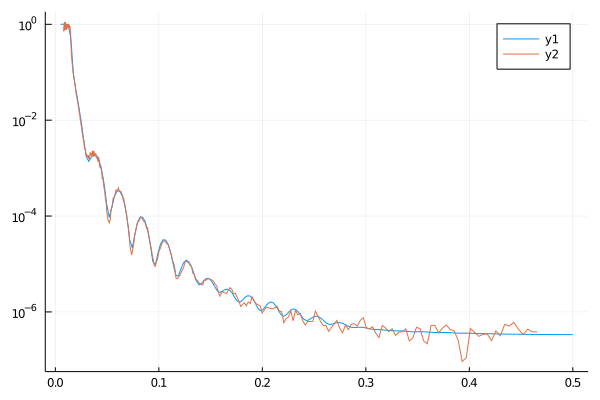

In [21]:
x = collect(range(0.0051, 0.5; length=201))
y = generative(model, x)
plot(x, y, yaxis=:log)
plot!(data)

In [22]:
d = Uniform(-Inf, Inf)

Uniform{Float64}(a=-Inf, b=Inf)

In [23]:
using BenchmarkTools

In [28]:
start = log10(0.005)
finish = log10(0.2)
interpnum = 1500

@benchmark xlin = 10 .^ LinRange(start, finish, Int(interpnum))

BenchmarkTools.Trial: 
  memory estimate:  12.02 KiB
  allocs estimate:  4
  --------------
  minimum time:     32.829 μs (0.00% GC)
  median time:      33.998 μs (0.00% GC)
  mean time:        34.910 μs (0.00% GC)
  maximum time:     112.293 μs (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     1

In [29]:
@benchmark begin xtemp = range(start, finish, length=Int(interpnum))
xlin = zeros(size(xtemp, 1))
for i = 1:size(xtemp, 1)
    xlin[i] = 10. ^ xtemp[i]
end
end

BenchmarkTools.Trial: 
  memory estimate:  136.69 KiB
  allocs estimate:  6485
  --------------
  minimum time:     223.462 μs (0.00% GC)
  median time:      235.142 μs (0.00% GC)
  mean time:        251.296 μs (5.29% GC)
  maximum time:     5.103 ms (93.90% GC)
  --------------
  samples:          10000
  evals/sample:     1